# PyTorch 数据增强 (Data Augmentation) 完整教程

本教程涵盖常用的图像变换操作，包括：
- 基础变换：ToTensor, Normalize, Resize
- 裁剪操作：RandomCrop, CenterCrop
- 翻转操作：RandomHorizontalFlip, RandomVerticalFlip
- 旋转操作：RandomRotation
- 颜色增强：ColorJitter, RandomGrayscale
- 组合变换：Compose

**学习目标**：掌握如何使用 torchvision.transforms 进行数据增强

## 1. 导入必要的库

In [8]:
import torch
import cv2
import os
import numpy as np
from PIL import Image  # PIL 是 torchvision.transforms 推荐使用的图像格式
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

# 设置中文字体（避免 matplotlib 显示中文时出现乱码）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

print("✅ 库导入成功！")

✅ 库导入成功！


## 2. 读取测试图片

PIL 图片尺寸: (500, 375)
OpenCV 图片形状: (375, 500, 3)


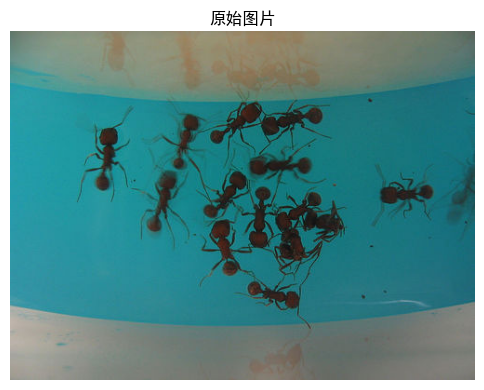

In [ ]:
# 定义图像路径
img_path = r'data\train\ants_image\5650366_e22b7e1065.jpg'

# 使用 PIL 读取图片（推荐方式，因为 torchvision.transforms 默认支持 PIL）
img_pil = Image.open(img_path)

# 也可以用 OpenCV 读取，但需要转换
img_cv = cv2.imread(img_path)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# 显示原始图片信息
print(f"PIL 图片尺寸: {img_pil.size}")  # (宽, 高)
print(f"OpenCV 图片形状: {img_cv.shape}")  # (高, 宽, 通道)

# 显示原始图片
plt.figure(figsize=(6, 6))
plt.imshow(img_pil)
plt.title("原始图片")
plt.axis('off')
plt.show()

## 3. 基础变换

### 3.1 ToTensor - 转换为张量

In [ ]:
# 实例化 ToTensor 工具
to_tensor = transforms.ToTensor()

# 执行转换
# 1. 维度转换：(H, W, C) -> (C, H, W)  <--- PyTorch 喜欢的格式
# 2. 归一化：[0, 255] -> [0.0, 1.0]
# 3. 数据类型：uint8 -> float32
tensor_img = to_tensor(img_pil)

print(f"Tensor 形状: {tensor_img.shape}")  # torch.Size([C, H, W])
print(f"Tensor 数据类型: {tensor_img.dtype}")
print(f"Tensor 数值范围: [{tensor_img.min():.3f}, {tensor_img.max():.3f}]")

# ================= 可视化验证 (改为 plt 形式) =================

# .permute(1, 2, 0) 的意思就是：
# 把原来的第1个维度(H)放到第0位
# 把原来的第2个维度(W)放到第1位
# 把原来的第0个维度(C)放到第2位
img_for_plt = tensor_img.permute(1, 2, 0)

plt.figure(figsize=(6, 6))
# 此时 img_for_plt 已经是 (H, W, C) 且数值在 [0, 1] 之间，plt 可以完美显示
plt.imshow(img_for_plt)
plt.title(f"ToTensor Result\nShape: {tensor_img.shape}")
plt.axis('off')
plt.show()

print("✅ 可视化完成！这一步主要是为了验证 Tensor 的转换是否正确。")

Tensor 形状: torch.Size([3, 375, 500])
Tensor 数据类型: torch.float32
Tensor 数值范围: [0.000, 0.753]
✅ 处理完成！图片已保存到 TensorBoard logs 文件夹。
👉 在终端运行此命令查看: tensorboard --logdir=logs


### 3.2 Normalize - 标准化

公式：`output = (input - mean) / std`

常用参数（ImageNet 预训练模型）：
- mean = [0.485, 0.456, 0.406]  # RGB 三通道的均值
- std = [0.229, 0.224, 0.225]   # RGB 三通道的标准差

In [11]:
# 定义标准化操作
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],  # ImageNet 数据集的均值
    std=[0.229, 0.224, 0.225]    # ImageNet 数据集的标准差
)

# 先转为 Tensor，再标准化
normalized_img = normalize(tensor_img)

print(f"标准化后的数值范围: [{normalized_img.min():.3f}, {normalized_img.max():.3f}]")
print("⚠️ 注意：标准化后的图片不能直接显示，因为像素值可能为负数")

标准化后的数值范围: [-2.118, 1.420]
⚠️ 注意：标准化后的图片不能直接显示，因为像素值可能为负数


### 3.3 Resize - 调整大小

In [ ]:
# 定义调整大小操作
resize = transforms.Resize((256, 256))  # (高, 宽)

# 对 PIL 图片进行缩放
resized_img = resize(img_pil)

print(f"原始尺寸: {img_pil.size}")
print(f"调整后尺寸: {resized_img.size}")

# 显示对比
# 创建了一个“画板”和两个“子图”。切分出两个格子的布局，左边放一个，右边放一个。
# 设定整个大图（画板）的尺寸是 宽 12 英寸，高 6 英寸。
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_pil)
axes[0].set_title(f"原始图片 {img_pil.size}")
axes[0].axis('off')

axes[1].imshow(resized_img)
axes[1].set_title(f"Resize 后 {resized_img.size}")
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 4. 裁剪操作

### 4.1 RandomCrop - 随机裁剪

In [ ]:
# 定义随机裁剪（每次运行结果不同）
random_crop = transforms.RandomCrop((200, 200))  # 裁剪成 200x200

# 多次裁剪，观察随机性
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    cropped_img = random_crop(img_pil)
    axes[i].imshow(cropped_img)
    axes[i].set_title(f"随机裁剪 #{i+1}")
    axes[i].axis('off')

plt.suptitle("RandomCrop - 每次裁剪位置不同", fontsize=16)
plt.tight_layout()
plt.show()

### 4.2 CenterCrop - 中心裁剪

In [ ]:
# 定义中心裁剪（总是从中心裁剪，结果固定）
center_crop = transforms.CenterCrop((200, 200))

# 执行中心裁剪
center_cropped_img = center_crop(img_pil)

# 显示对比
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_pil)
axes[0].set_title("原始图片")
axes[0].axis('off')

axes[1].imshow(center_cropped_img)
axes[1].set_title("CenterCrop - 从中心裁剪")
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 5. 翻转操作

### 5.1 RandomHorizontalFlip - 随机水平翻转

In [ ]:
# 定义随机水平翻转（p=0.5 表示有 50% 的概率翻转）
h_flip = transforms.RandomHorizontalFlip(p=1.0)  # p=1.0 表示必定翻转（为了演示）

# 执行水平翻转
h_flipped_img = h_flip(img_pil)

# 显示对比
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_pil)
axes[0].set_title("原始图片")
axes[0].axis('off')

axes[1].imshow(h_flipped_img)
axes[1].set_title("水平翻转")
axes[1].axis('off')
plt.tight_layout()
plt.show()

### 5.2 RandomVerticalFlip - 随机垂直翻转

In [ ]:
# 定义随机垂直翻转
v_flip = transforms.RandomVerticalFlip(p=1.0)

# 执行垂直翻转
v_flipped_img = v_flip(img_pil)

# 显示对比
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_pil)
axes[0].set_title("原始图片")
axes[0].axis('off')

axes[1].imshow(v_flipped_img)
axes[1].set_title("垂直翻转")
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 6. 旋转操作

### 6.1 RandomRotation - 随机旋转

In [ ]:
# 定义随机旋转（degrees 参数指定旋转角度范围）
rotation = transforms.RandomRotation(degrees=45)  # 在 [-45°, 45°] 之间随机旋转

# 多次旋转，观察随机性
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    rotated_img = rotation(img_pil)
    axes[i].imshow(rotated_img)
    axes[i].set_title(f"随机旋转 #{i+1}")
    axes[i].axis('off')

plt.suptitle("RandomRotation - 每次旋转角度不同 (±45°)", fontsize=16)
plt.tight_layout()
plt.show()

## 7. 颜色增强

### 7.1 ColorJitter - 颜色抖动

In [ ]:
# 定义颜色抖动
# brightness: 亮度调整范围 [1-0.3, 1+0.3] = [0.7, 1.3]
# contrast: 对比度调整范围
# saturation: 饱和度调整范围
# hue: 色调调整范围 [-0.1, 0.1]
color_jitter = transforms.ColorJitter(
    brightness=0.3,
    contrast=0.3,
    saturation=0.3,
    hue=0.1
)

# 多次应用，观察效果
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    jittered_img = color_jitter(img_pil)
    axes[i].imshow(jittered_img)
    axes[i].set_title(f"颜色抖动 #{i+1}")
    axes[i].axis('off')

plt.suptitle("ColorJitter - 随机调整亮度/对比度/饱和度/色调", fontsize=16)
plt.tight_layout()
plt.show()

### 7.2 RandomGrayscale - 随机灰度化

In [ ]:
# 定义随机灰度化（p=0.5 表示有 50% 的概率转为灰度图）
grayscale = transforms.RandomGrayscale(p=1.0)  # p=1.0 表示必定转为灰度（为了演示）

# 执行灰度化
grayscale_img = grayscale(img_pil)

# 显示对比
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_pil)
axes[0].set_title("原始彩色图片")
axes[0].axis('off')

axes[1].imshow(grayscale_img)
axes[1].set_title("灰度图")
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 8. 组合变换 - Compose

在实际训练中，我们通常需要组合多个变换操作

In [ ]:


# ============================================================
# 1. 训练集预处理流程 (Train Transform)
# ============================================================
# 核心逻辑：尽可能地“折腾”图片。
# 目的：让模型没法“硬背”原图，强迫它学会识别物体的本质特征（比如：歪着的猫也是猫，变暗的猫也是猫）。
train_transform = transforms.Compose([
    # 【第一步：尺寸统一】
    # 为什么是 256？通常我们最后输入模型的是 224x224。
    # 先缩放到比 224 大一点的 256，是为了留出后面“随机裁剪”的空间。
    transforms.Resize((256, 256)),              

    # 【第二步：空间几何增强】
    # 1. 随机裁剪：在 256 的图里随机抠出一块 224 的图。
    # 作用：让模型不仅能识别图片正中间的物体，偏一点也能认识。
    transforms.RandomCrop((224, 224)),          
    
    # 2. 随机水平翻转：比如 50% 概率把图片左右镜像。
    # 作用：模拟真实世界（左脸和右脸都是脸），瞬间让数据量翻倍。
    transforms.RandomHorizontalFlip(p=0.5),     
    
    # 3. 随机旋转：在 -15度 到 +15度 之间随便转一下。
    # 作用：增加对倾斜角度的容忍度。
    transforms.RandomRotation(degrees=15),      

    # 【第三步：颜色增强】
    # 颜色抖动：模拟不同的光照环境（白天、阴天、过曝、过暗）。
    transforms.ColorJitter(                     
        brightness=0.2,   # 亮度波动 ±20%
        contrast=0.2,     # 对比度波动 ±20%
        saturation=0.2,   # 饱和度波动 ±20%
        hue=0.1           # 色调波动 ±10%
    ),

    # 【第四步：格式转换 (必须步骤)】
    # 将 PIL 图片 (整数 0-255, HWC格式) 转换为 Tensor (浮点数 0.0-1.0, CHW格式)。
    # 注意：在这一步之前，图片还是看图软件能打开的格式；这一步之后，就是数学矩阵了。
    transforms.ToTensor(),                      

    # 【第五步：数学标准化 (必须步骤)】
    # 公式：(像素值 - 均值) / 标准差
    # 作用：把数据拉回到 0 附近，让神经网络训练更稳定、收敛更快。
    # 这里的数字是 ImageNet 数据集的统计值，是业界的“出厂默认设置”。
    transforms.Normalize(                       
        mean=[0.485, 0.456, 0.406], # R, G, B 三通道均值
        std=[0.229, 0.224, 0.225]   # R, G, B 三通道标准差
    )
])

# ============================================================
# 2. 验证集/测试集预处理流程 (Val Transform)
# ============================================================
# 核心逻辑：严谨、固定、不折腾。
# 目的：考试的时候不能瞎改题目。我们要评估模型在“标准情况”下的表现，所以不能有随机性。
val_transform = transforms.Compose([
    # 1. 尺寸统一：这一步必须和训练集保持一致，先把图缩放到 256。
    transforms.Resize((256, 256)),

    # 2. 中心裁剪：这里不能用 RandomCrop！
    # 必须用 CenterCrop（只裁正中间），保证同一张图不管测多少次，结果都是一模一样的。
    transforms.CenterCrop((224, 224)),          

    # 3. 转 Tensor：必须做。
    transforms.ToTensor(),

    # 4. 标准化：必须做，且参数必须和训练集一模一样！
    # 就像你平时练习（训练）用的尺子是这把，考试（验证）时也得用同一把尺子。
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("✅ 训练集和验证集的变换流程已定义！")
# print(f"\n训练集变换流程：\n{train_transform}")
# print(f"\n验证集变换流程：\n{val_transform}")

### 8.1 可视化组合变换效果

In [ ]:
# ============================================================
# 1. 定义“可视化专用”的变换流程
# ============================================================
# ❓ 疑问：为什么单独写一个 visual_transform？直接用前面的 train_transform 不行吗？
# 💡 解答：不行。因为 train_transform 最后包含了 ToTensor 和 Normalize。
#         Normalize 会把像素变成负数（比如 -1.5），Matplotlib 画这种图会显示一片漆黑或者报错。
#         所以这里我们只保留“变形”的操作，去掉“数学计算”的操作，专门用来给人眼看。
visual_transform = transforms.Compose([
    transforms.Resize((256, 256)),              # 第一步：先把图放大一点，方便后面裁
    transforms.RandomCrop((224, 224)),          # 第二步：随机切一块（每次切的位置都不一样）
    transforms.RandomHorizontalFlip(p=0.5),     # 第三步：抛硬币，正面朝上就水平翻转
    transforms.RandomRotation(degrees=15),      # 第四步：随机歪脑袋（旋转）
    transforms.ColorJitter(                     # 第五步：随机调色（模拟不同光照）
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
    )
    # 注意：这里没有 ToTensor 和 Normalize，输出的还是 PIL 图片，方便直接画图。
])

# ============================================================
# 2. 创建画布：3行4列的网格
# ============================================================
# figsize=(16, 12) 表示整个大图的长宽（英寸）。
# fig 是整张大纸，axes 是里面切出来的 12 个小格子。
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# 🔧 技巧：axes 原本是一个 3x4 的二维数组（矩阵），不好遍历。
# .flatten() 把它拍扁成一个一维数组（列表），里面有 12 个元素 [ax0, ax1, ... ax11]。
# 这样我们后面就可以直接用 axes[i] 来找格子了，不用写 axes[row][col]。
axes = axes.flatten()

# ============================================================
# 3. 占据第 0 个格子：放原图作为对比
# ============================================================
# 这是一个好的习惯：展示增强效果时，永远把“原图”放在第一个，作为基准。
axes[0].imshow(img_pil)
axes[0].set_title("原始图片", fontsize=12, fontweight='bold')
axes[0].axis('off')  # 关掉坐标轴刻度，不然丑丑的

# ============================================================
# 4. 占据第 1 到第 11 个格子：放增强后的图
# ============================================================
# range(1, 12) 表示从索引 1 开始，一直到 11（不包含 12），正好填满剩下 11 个格子。
for i in range(1, 12):
    # 🎲 关键点：每次调用 visual_transform(img) 时，里面的“Random”操作都会重新“掷骰子”。
    # 所以虽然输入代码一样，但每次循环生成的 augmented_img 都是不一样的！
    augmented_img = visual_transform(img_pil)
    
    # 把变身后的图画在第 i 个格子里
    axes[i].imshow(augmented_img)
    axes[i].set_title(f"增强 #{i}", fontsize=12) # 给每个图编个号
    axes[i].axis('off')

# ============================================================
# 5. 调整布局并显示
# ============================================================
plt.suptitle("组合变换效果 - 每次都不同！", fontsize=18, fontweight='bold') # 给整张大纸加个总标题
plt.tight_layout() # 自动调整子图之间的间距，防止标题和图片重叠（治愈强迫症）
plt.show() # 弹窗显示

## 9. 保存到 TensorBoard

将变换后的图片保存到 TensorBoard 中查看

In [ ]:
# 创建 TensorBoard 记录器
writer = SummaryWriter("logs/transforms")

# 记录原始图片
img_array = np.array(img_pil)
writer.add_image("原始图片", img_array, global_step=0, dataformats='HWC')

# 记录多个增强后的图片
for i in range(10):
    augmented_img = visual_transform(img_pil)
    augmented_array = np.array(augmented_img)
    writer.add_image("数据增强", augmented_array, global_step=i+1, dataformats='HWC')

writer.close()
print("✅ 图片已保存到 TensorBoard！")
print("📊 运行命令查看: tensorboard --logdir=logs/transforms")

## 10. 总结

### 📌 常用变换速查表

| 变换名称 | 功能 | 常用参数 | 使用场景 |
|---------|------|---------|----------|
| `ToTensor()` | 转为 Tensor | 无 | **必须使用** |
| `Normalize()` | 标准化 | mean, std | **必须使用**（训练深度学习模型时） |
| `Resize()` | 调整大小 | size | 统一图片尺寸 |
| `RandomCrop()` | 随机裁剪 | size | **训练集**数据增强 |
| `CenterCrop()` | 中心裁剪 | size | **验证集**固定裁剪 |
| `RandomHorizontalFlip()` | 随机水平翻转 | p=0.5 | **训练集**增强（分类任务） |
| `RandomVerticalFlip()` | 随机垂直翻转 | p=0.5 | 医学影像、卫星图像 |
| `RandomRotation()` | 随机旋转 | degrees | **训练集**增强 |
| `ColorJitter()` | 颜色抖动 | brightness, contrast, saturation, hue | **训练集**增强 |
| `RandomGrayscale()` | 随机灰度化 | p | 特殊场景增强 |
| `Compose()` | 组合多个变换 | list of transforms | **组合多个操作** |

### 💡 最佳实践

1. **训练集**：使用丰富的数据增强（随机裁剪、翻转、旋转、颜色抖动等）
2. **验证集/测试集**：只做基础变换（Resize → CenterCrop → ToTensor → Normalize）
3. **Normalize 的 mean 和 std**：
   - 使用预训练模型时，必须使用 ImageNet 的参数
   - 自己训练时，可以计算自己数据集的均值和标准差
4. **变换顺序很重要**：
   - 先做几何变换（裁剪、翻转、旋转）
   - 再做颜色变换（ColorJitter）
   - 最后转为 Tensor 并标准化

### 🎯 下一步学习

- 学习 `DataLoader` 批量加载数据
- 将自定义 Dataset 与 transforms 结合使用
- 构建第一个分类模型并训练